# Potato, Bell Pepper and Tomato Diseases Classification with CNN: Pre Trained Model

## 1. Setup the dataset

import tensorflow as tf

IMG_SIZE = (224, 224)   # MobileNetV2 default
BATCH_SIZE = 32
data = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/PlantVillage"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.


## 2. Preprocess the data

In [3]:
from tensorflow.keras import layers

# Normalize (MobileNet expects [0, 1] scaled inputs)
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)

## 3. Build model with MobileNetV2

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

# Load pretrained base (no top layers)
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base model (so we only train the new top layers)
base_model.trainable = False

# Add new classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Compile the model

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Train the model

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 352s 672ms/step - accuracy: 0.5956 - loss: 1.3101 - val_accuracy: 0.8595 - val_loss: 0.4476
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 339s 656ms/step - accuracy: 0.8547 - loss: 0.4540 - val_accuracy: 0.8837 - val_loss: 0.3632
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 350s 678ms/step - accuracy: 0.8786 - loss: 0.3696 - val_accuracy: 0.8917 - val_loss: 0.3316
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 344s 666ms/step - accuracy: 0.8966 - loss: 0.3155 - val_accuracy: 0.9009 - val_loss: 0.2925
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 340s 659ms/step - accuracy: 0.9023 - loss: 0.2994 - val_accuracy: 0.9067 - val_loss: 0.2875
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 344s 666ms/step - accuracy: 0.8992 - loss: 0.2886 - val_accuracy: 0.9072 - val_loss: 0.2757
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 336s 651ms/step - accuracy: 0.9080 - loss: 0.2698 - val_accuracy: 0.9057 - val_loss: 0.2643
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 336s 650ms/step - accuracy: 0.9147 -

## 6. Evaluate the model

In [7]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.3f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 68s 529ms/step - accuracy: 0.9075 - loss: 0.2682 
Validation accuracy: 0.911


## 7. Plot the learning rate

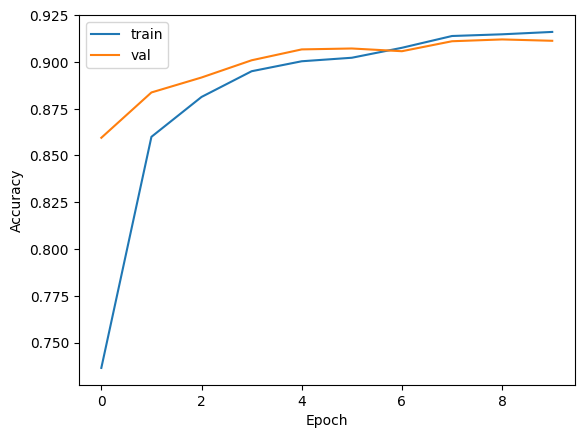

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 8. Fine tunning for higher accuracy

In [9]:
base_model.trainable = True

# But keep lower layers frozen (they detect generic features)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 523s 990ms/step - accuracy: 0.6621 - loss: 1.5802 - val_accuracy: 0.8910 - val_loss: 0.3221
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 483s 936ms/step - accuracy: 0.8656 - loss: 0.4027 - val_accuracy: 0.9021 - val_loss: 0.2978
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 484s 937ms/step - accuracy: 0.9044 - loss: 0.2841 - val_accuracy: 0.9145 - val_loss: 0.2434
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 455s 881ms/step - accuracy: 0.9270 - loss: 0.2111 - val_accuracy: 0.9292 - val_loss: 0.2068
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 442s 857ms/step - accuracy: 0.9474 - loss: 0.1572 - val_accuracy: 0.9385 - val_loss: 0.1764
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 451s 874ms/step - accuracy: 0.9569 - loss: 0.1292 - val_accuracy: 0.9443 - val_loss: 0.1548
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 474s 919ms/step - accuracy: 0.9677 - loss: 0.1000 - val_accuracy: 0.9506 - val_loss: 0.1388
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 451s 873ms/step - accuracy: 0.9723 -

## 9. Save the model

In [10]:
model.save("all_diseases_classifier_pretrained.h5")

## 10. Prediction

In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/00a538f3-8421-43ab-9e6f-758d36180dd3___YLCV_NREC 2667.jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) / 255.0  # normalize

pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]
print(f"Predicted class: {pred_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
Predicted class: Tomato__Tomato_YellowLeaf__Curl_Virus


## Conclusion
1. The accuracy with pre trained model is around 0.95. It is really good for original dataset since the dataset contains imbalance.
2. Try to do balancing the target by doing augmentation to minority target and under sampling for the majority target.